In [ ]:
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt


img1 = cv2.imread('/content/drive/MyDrive/Photo/3.png', 0)
img2 = cv2.imread('/content/drive/MyDrive/Photo/3_2.png', 0)



def gloh_flann_matcher(img2, matches_number):

  gloh = cv2.xfeatures2d.SIFT_create()
  matcher = cv2.FlannBasedMatcher_create()
  kp1, desc1 = gloh.detectAndCompute(img1, None)
  kp2, desc2 = gloh.detectAndCompute(img2, None)
  matches = matcher.match(desc1, desc2)
  matches = sorted(matches, key=lambda x: x.distance)

  return cv2.drawMatches(img1, kp1, img2, kp2, matches[:matches_number], None, flags=4)


def gloh_custom_matcher(img2, matches_number=10):

  gloh = cv2.xfeatures2d.SIFT_create()
  kp1, desc1 = gloh.detectAndCompute(img1, None)
  kp2, desc2 = gloh.detectAndCompute(img2, None)
  matches = []
  for i, d1 in enumerate(desc1, start=0):
      for j, d2 in enumerate(desc2, start=0):
          matches.append(cv2.DMatch(_trainIdx=j, _queryIdx=i, _distance=np.linalg.norm(d1 - d2, ord=2), _imgIdx=0))

  matches = sorted(matches, key=lambda sample: sample.distance)

  return cv2.drawMatches(img1, kp1, img2, kp2, matches[:matches_number], None, flags=4)

def ransac(matches, kp1, kp2, iterations=2000, threshold=5):
    best_inliers = []
    for _ in range(iterations):
        samples = random.sample(matches, 4)
        src_pts = np.array([kp1[sample.queryIdx].pt for sample in samples]).reshape(-1,1,2)
        dst_pts = np.array([kp2[sample.trainIdx].pt for sample in samples]).reshape(-1,1,2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, threshold)

        inliers = []
        for sample in matches:
            src_pt = np.array(kp1[sample.queryIdx].pt).reshape(-1,1,2)
            dst_pt = np.array(kp2[sample.trainIdx].pt).reshape(-1,1,2)
            transformed_pt = cv2.perspectiveTransform(src_pt, H)
            dist = np.linalg.norm(dst_pt - transformed_pt)
            if dist < threshold:
                inliers.append(sample)

        if len(inliers) > len(best_inliers):
            best_inliers = inliers

    src_pts = np.array([kp1[sample.queryIdx].pt for sample in best_inliers]).reshape(-1,1,2)
    dst_pts = np.array([kp2[sample.trainIdx].pt for sample in best_inliers]).reshape(-1,1,2)
    H, _ = cv2.findHomography(src_pts, dst_pts, 0)

    return H, best_inliers

def gloh_ransac_matcher(img2, matches_number):
    gloh = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = gloh.detectAndCompute(img1, None)
    kp2, des2 = gloh.detectAndCompute(img2, None)

    matcher = cv2.FlannBasedMatcher_create()
    matches = matcher.match(des1, des2)

    H, inliers = ransac(matches, kp1, kp2)

    return cv2.drawMatches(img1, kp1, img2, kp2, inliers[:matches_number], None, flags=4)


def visualize(image):
    plt.figure(figsize=(12, 12))
    plt.imshow(image)


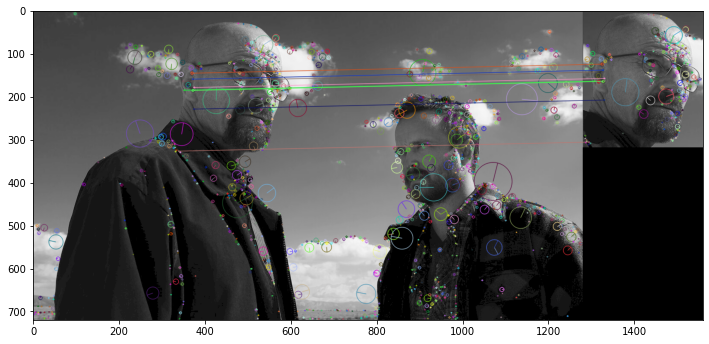

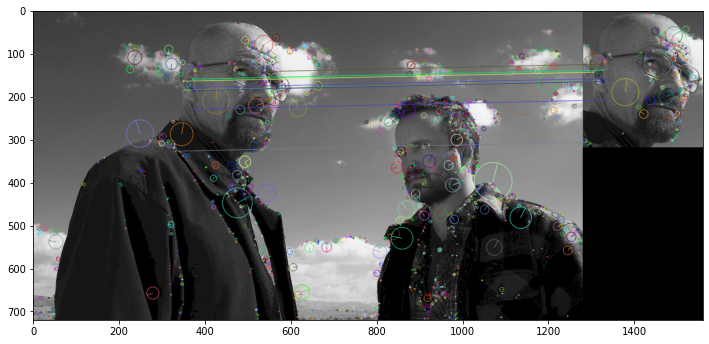

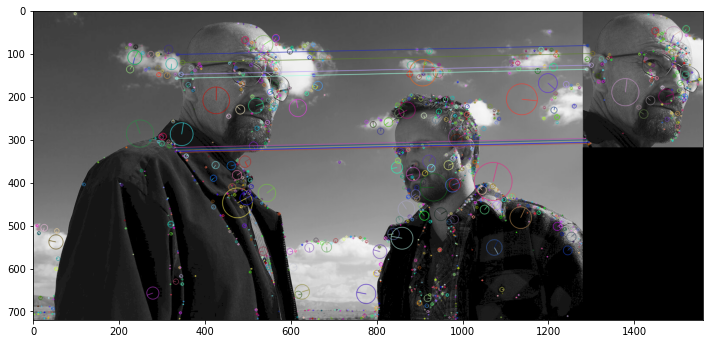

In [ ]:
visualize(image=gloh_flann_matcher(img2, matches_number=10))
visualize(image=gloh_custom_matcher(img2, matches_number=10))
visualize(image=gloh_ransac_matcher(img2, matches_number=10))

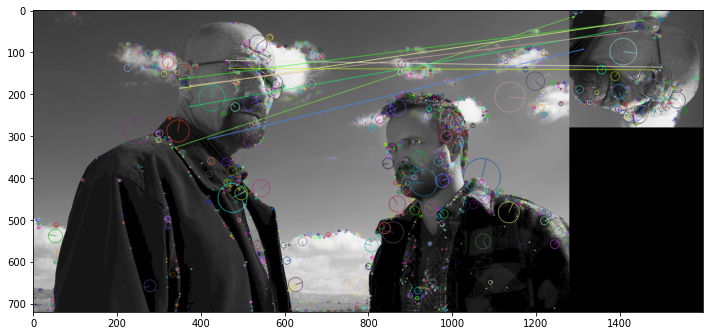

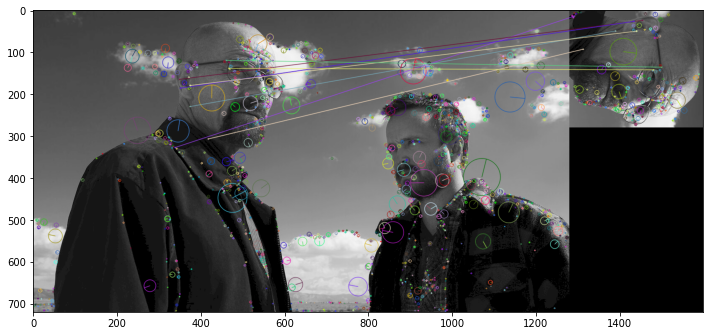

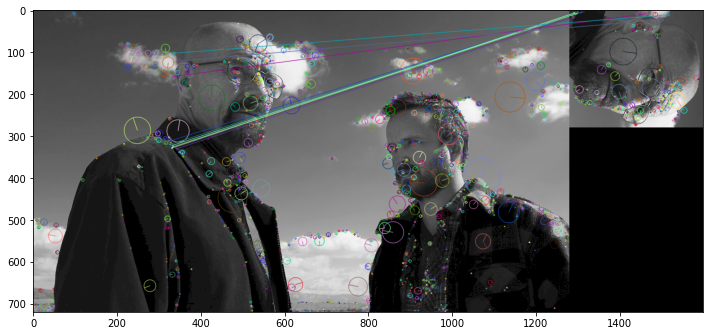

In [ ]:
img90 = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
visualize(image=gloh_flann_matcher(img90, matches_number=10))
visualize(image=gloh_custom_matcher(img90, matches_number=10))
visualize(image=gloh_ransac_matcher(img90, matches_number=10))